# Growth curves fit
In this notebook I try different approaches to fit the growth curves, the first part contains the most recent results where I fit OD < 0.4

In [1]:
import os
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import scipy.optimize as optimize
from findiff import FinDiff, coefficients, Coefficient

In [2]:
from lmfit.models import ExpressionModel, StepModel, LinearModel
import lmfit

In [3]:
# SET THE WORKING DIRECTORY
CWD = '/Users/miguel/Documents/Internship_CENTURI'
os.chdir(CWD)

In [64]:
## DEFINES WORKING CONSTANTS
#FILENAME = args.filename
FILENAME = 'gc_wt.csv'
SAVE_FN = FILENAME.strip().split('.')[0]

In [2]:
# Reads the dataframe with the growth curve data
FILE_PATH = os.path.join(os.getcwd(), "data", FILENAME)
df = pd.read_csv(FILE_PATH)
df.name = FILENAME.split('.')[0]
col_names = df.columns.values[1:-1]

NameError: name 'os' is not defined

## Define the models used to fit, logistic with and without a shift in the vertical asymptote, and a logistic + linear model

In [10]:
def logistic(x, K, C, Q, B, nu):
    '''
        K : carrying capacity
        A : left asymptote
        
    '''
    logistic_den = np.float_power(C + Q * np.exp(-B * x), 1 / nu)
    logistic = K / logistic_den
    return logistic

In [11]:
def simple_logistic(x, K, Q, B, nu):
    '''
        K : carrying capacity
        A : left asymptote
        
    '''
    logistic_den = np.float_power(1 + Q * np.exp(-B * x), 1 / nu)
    logistic = K / logistic_den
    return logistic

In [12]:
def log_lin(x, K, Q, B, nu, m, b):
    '''
        K : carrying capacity
        A : left asymptote
        
    '''
    logistic_den = np.float_power(1 + Q * np.exp(-B * x), 1 / nu)
    logistic_num = K / logistic_den 
    linear = m * x +  b
    return logistic_num + linear

Let's fit a simple logistic curve to first part of the data to get an estimate of the replication rates

## Fitting the growth curves using the linear + sigmoid functions

In [13]:
def fit_gc(data, func, p0, columns, single_scattering = False):
    # The function fits logistic or logistic + linear function to the growth curves
    # Input is
    # data: dataframe where each column at indices [1:-1] is assumed to be a plate read
    # func: simple_logistic or lin_log
    # p0: initial point for optimization, size must coincide with number of parameters from func
    # single_scattering: considers the single scattering regime, thus discarding all data above 0.4 OD
     
    # For single scattering regime, we take only the OD values les or equal than 0.4
    params = {}
    # Array representing time
    X = np.arange(data.shape[0])
    # Temporary dictionary to store fit parameters
    params_name = []
    if len(p0) == 4:
        params_name = ["K", "Q", "B", "nu"]
    if len(p0) == 5:
        params_name = ["K", "C", "Q", "B", "nu"]
    elif len(p0) == 6:
        params_name = ["K", "Q", "B", "nu", "m", "b"]

    for i in columns:
        # Array with the OD values
        y = data[i].values
        if single_scattering:
            y = y[y <= 0.4]
            X = np.arange(y.shape[0])
        
        # Initial position for optimization, initially using the same for all columns
        # Might be column dependant
        # p0 = np.array([1, 0.5, 2, 2e-1, 3e-3, 0], dtype=np.longdouble)
        temp, cv = optimize.curve_fit(func, X, y, p0, maxfev = 1000000)
        params[i] = dict(zip(params_name, temp))
    
    return params      

In [39]:
def plot_fit_gc(data, func, params, single_scattering = False):
    nrows = len(params) // 2 + len(params) % 2
    fig, ax = plt.subplots(nrows = nrows, ncols = 2, figsize = (20, 6 * nrows), sharex = False)
    #fig.subplots_adjust(hspace=0)
    col_names = list(params.keys())
    size = None
    for i, col in enumerate(col_names):
        X = np.arange(data.shape[0])
        y = func(X, *list(params[col].values()))
        
        if single_scattering:
            size = data[data[col] < 0.4].shape[0]
            X = X[:size]
            y = y[:size]
        
        
        ax.flat[i].plot(X, data[col].values[:size], 'x', alpha = 0.5, label='data');
        ax.flat[i].plot(X, y, label='curve_fit');
        ax.flat[i].set_title(col);
        ax.flat[i].legend();
    fig.suptitle(f"{data.name}");
    plt.savefig(CWD + f"/data/fit_{data.name}.png", dpi=300);
    plt.show();

In [74]:
my_params = fit_gc(df, simple_logistic, np.array([4e-1, 4e17, 0.1, 2]), np.append(col_names,'Mean'), single_scattering=True)

/var/folders/j5/gzgbj85d7fl1z1qxpqp965kc0000gq/T/ipykernel_68823/683823598.py:7: RuntimeWarning: invalid value encountered in float_power
  logistic_den = np.float_power(1 + Q * np.exp(-B * x), 1 / nu)


In [75]:
pd.DataFrame(my_params)

,A5,B6,C7,D8,E1,E9,F10,G2,G11,H3,Mean
K,3.256927e+01,4.646538e+01,2.328841e+01,3.039445e+01,3.065577e+01,3.079621e+01,2.102899e+01,1.832132e+01,2.695564e+01,3.209351e+01,3.419643e+01
Q,1.067982e+13,9.798577e+12,1.115417e+13,1.182039e+13,1.295905e+13,9.100335e+12,7.733127e+12,6.781014e+12,1.113737e+13,9.145859e+12,1.297776e+13
B,2.133525e-01,1.982900e-01,2.009292e-01,1.878397e-01,2.248922e-01,2.029325e-01,2.085415e-01,1.895750e-01,2.136095e-01,2.165837e-01,2.019783e-01
nu,3.185820e+00,3.236565e+00,3.334290e+00,3.506921e+00,3.041284e+00,3.365843e+00,3.319232e+00,3.629704e+00,3.126145e+00,3.141552e+00,3.279456e+00


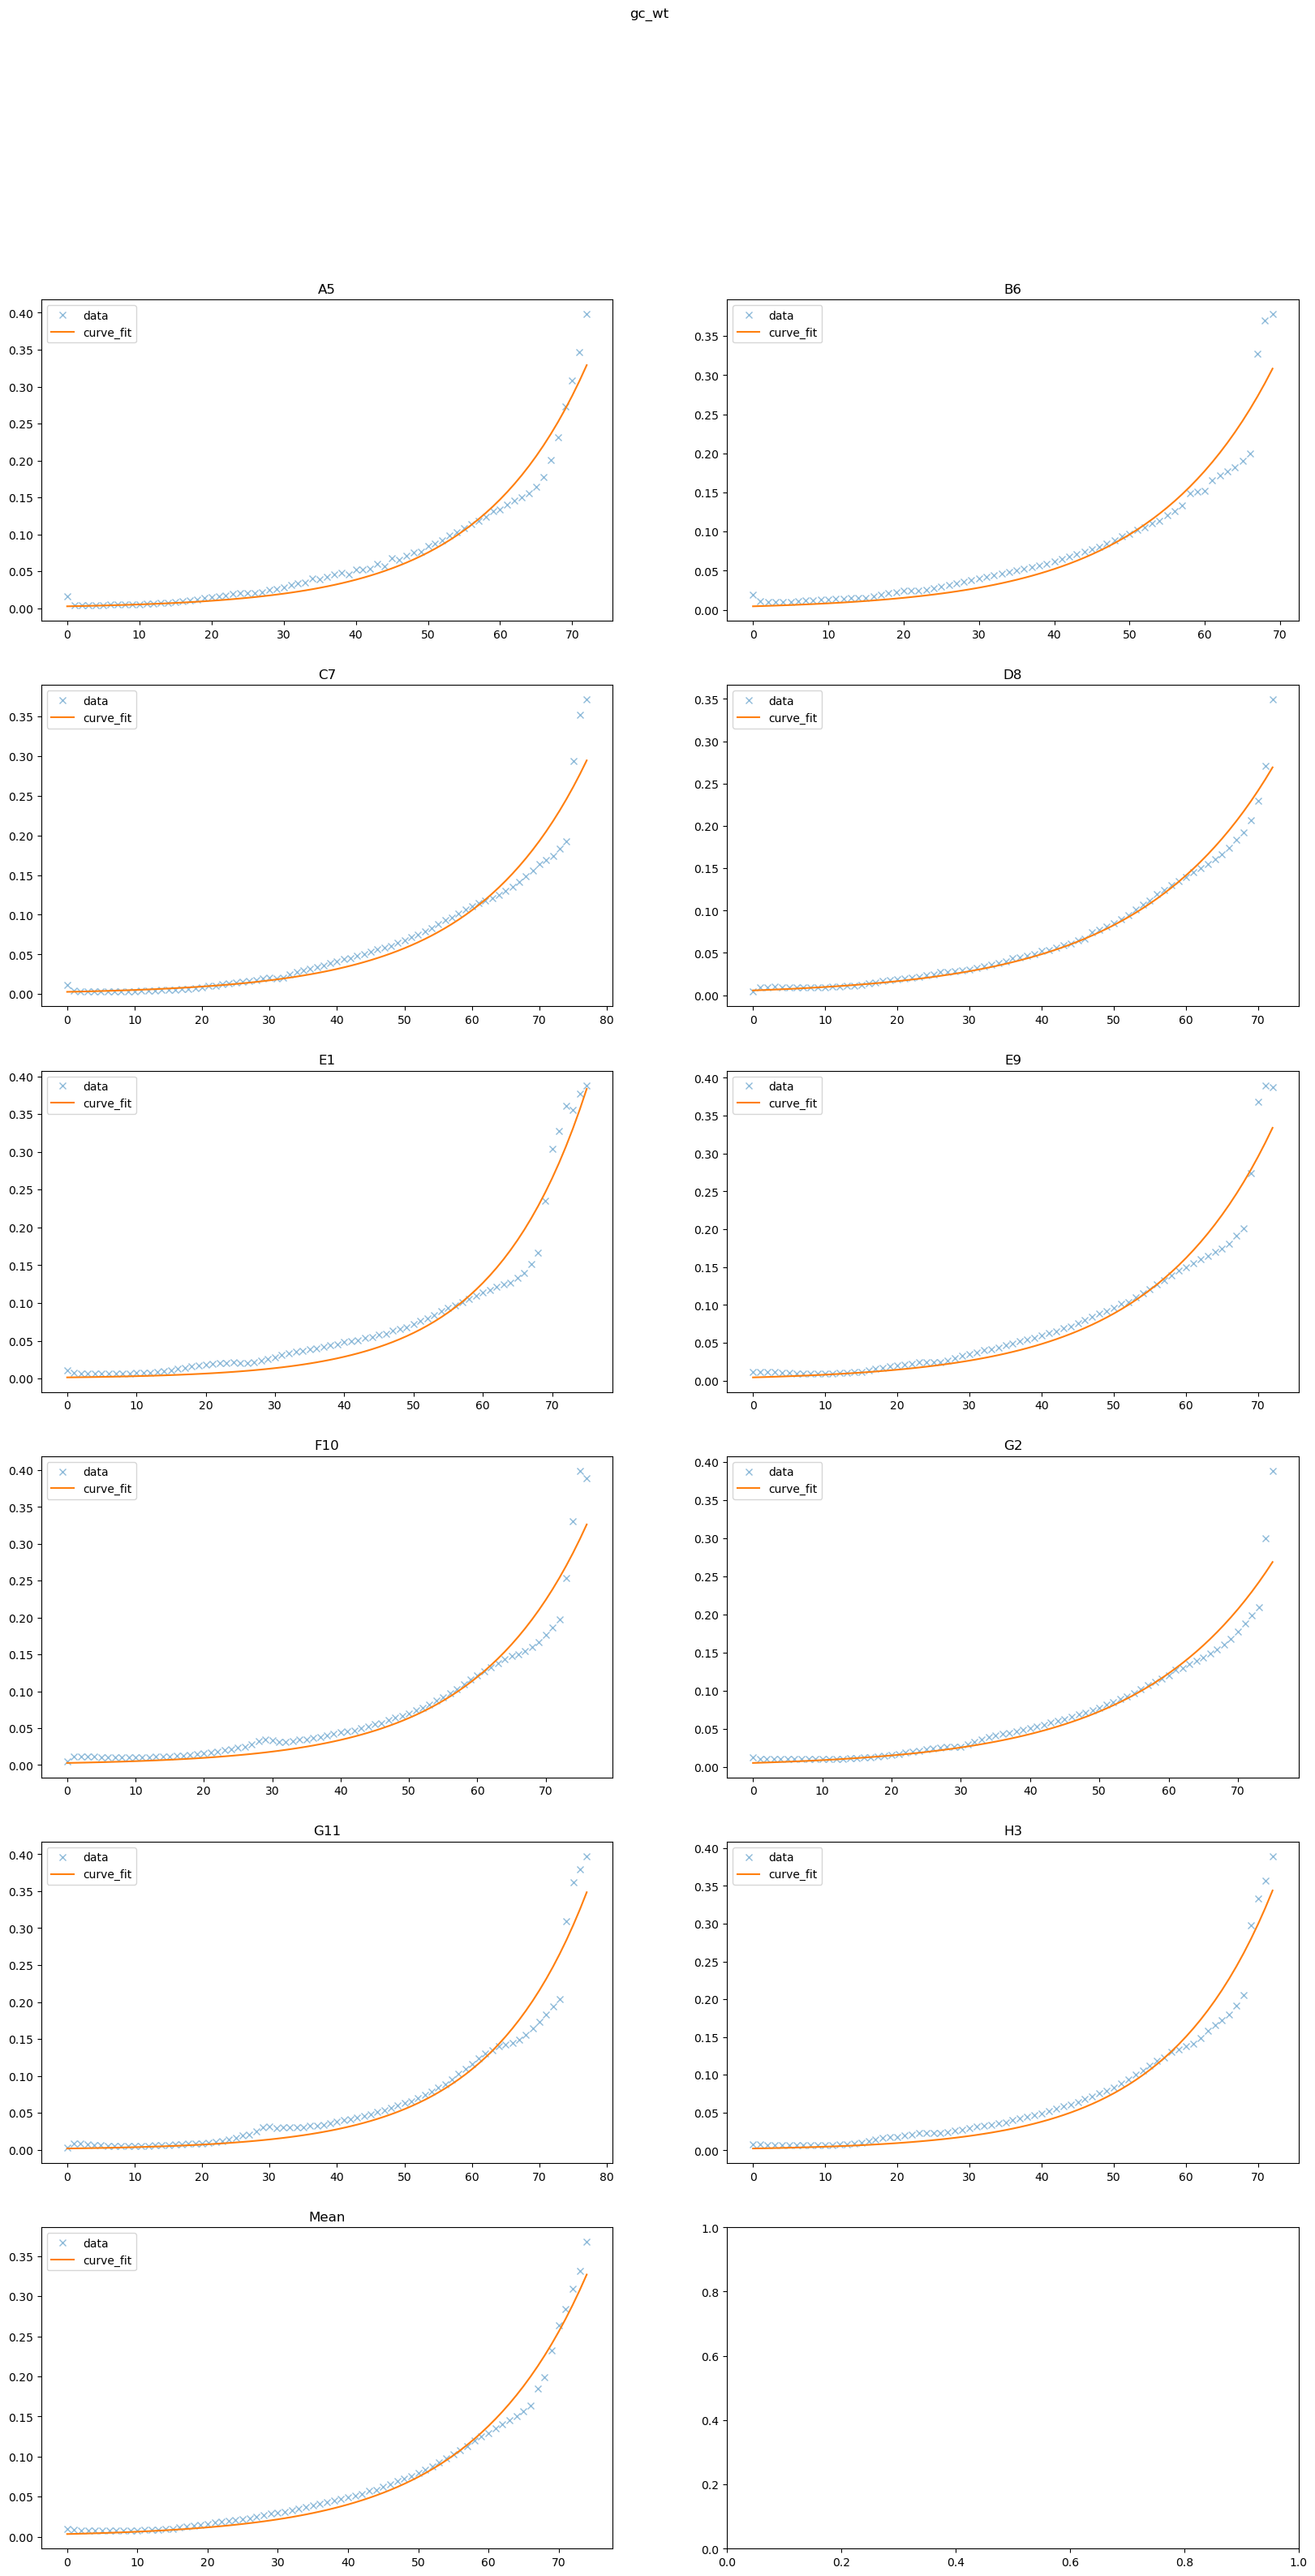

In [76]:
plot_fit_gc(df, simple_logistic, my_params, single_scattering = True)

# Using lmfit with the data with OD<0.4 to compare the fit

In [77]:
# Defining the data and the model
y = df['Mean'].values
y = y[y < 0.4]
X = np.arange(y.shape[0])
logistic_model = StepModel(form = 'logistic')

In [78]:
logistic_result = logistic_model.fit(y, x=X)

<Axes: title={'center': 'Model(step)'}, xlabel='x', ylabel='y'>

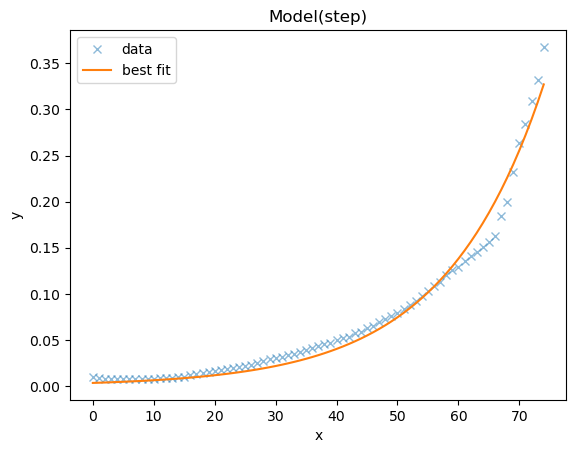

In [79]:
logistic_result.plot_fit(datafmt="x", data_kws={"alpha" : 0.5})

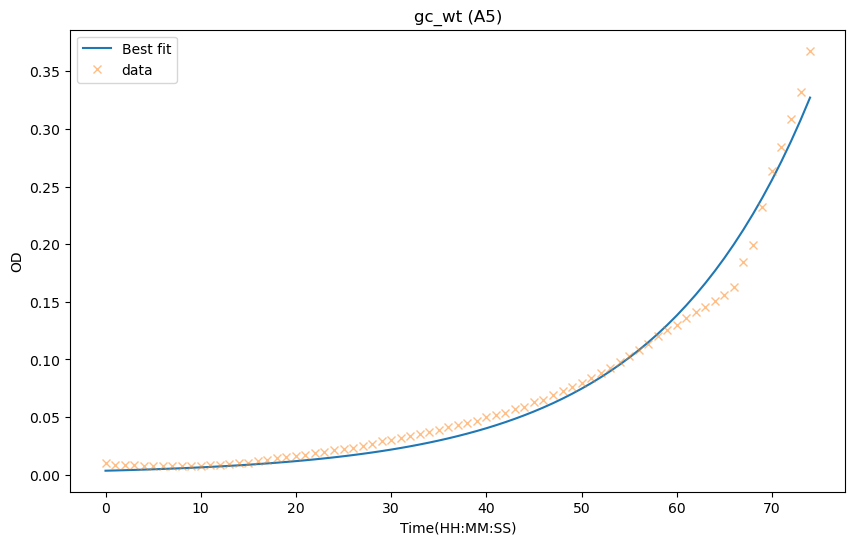

In [80]:
plt.figure(figsize = (10,6))
#plt.plot(X, result1.init_fit, '--', label='initial fit')
#plt.plot(X, result.best_fit, '-', label='best fit')
plt.plot(X, logistic_result.best_fit, '-', label='Best fit')
plt.plot(X, y, 'x', alpha = 0.5, label = 'data')
plt.legend();
#plt.xticks(X,list(df['Time'].values[X]));
plt.xlabel('Time(HH:MM:SS)');
plt.ylabel('OD');
plt.title(f'{df.name} ({col_names[0]})');
plt.savefig('gc_fit.png', dpi = 300);

In [51]:
def lmfit_gc(data, col_names, compare = False, my_params = None, func = None, single_scattering = False):
    # The function fits logistic or logistic + linear function to the growth curves
    # Input is
    # data: dataframe where each column at indices [1:-1] is assumed to be a plate read
    # col_names: names of the columns with the plate measurements
    # single_scattering: considers the single scattering regime, thus discarding all data above 0.4 OD
     
    # For single scattering regime, we take only the OD values les or equal than 0.4
    params = {}
    # Array representing time
    X = np.arange(data.shape[0])
    # Define the model
    model = StepModel(form = 'logistic') if single_scattering else StepModel(form = 'logistic') + LinearModel()

    # Plot the fits right away
    nrows = len(col_names)//2 + len(col_names) % 2
    fig, ax = plt.subplots(nrows = nrows, ncols = 2, figsize = (20, 6 * nrows), sharex = False)
    for i, col in enumerate(col_names):
        # Array with the OD values
        y = data[col].values
        
        if single_scattering:
            y = y[y <= 0.4]
            X = np.arange(y.shape[0])
        
        if compare:
            y_compare = func(X, *list(my_params[col].values()))
            ax.flat[i].plot(X, y_compare, label='my_fit', alpha = 0.6)

        logistic_result = logistic_model.fit(y, x=X)
        params[col] = logistic_result.best_values
        logistic_result.plot_fit(ax=ax.flat[i], datafmt="x", data_kws={"alpha" : 0.5})
        ax.flat[i].set_title(f"{col}");
        ax.flat[i].set_xlabel("Time step");
        ax.flat[i].set_ylabel("OD");

    plt.show()
    return params

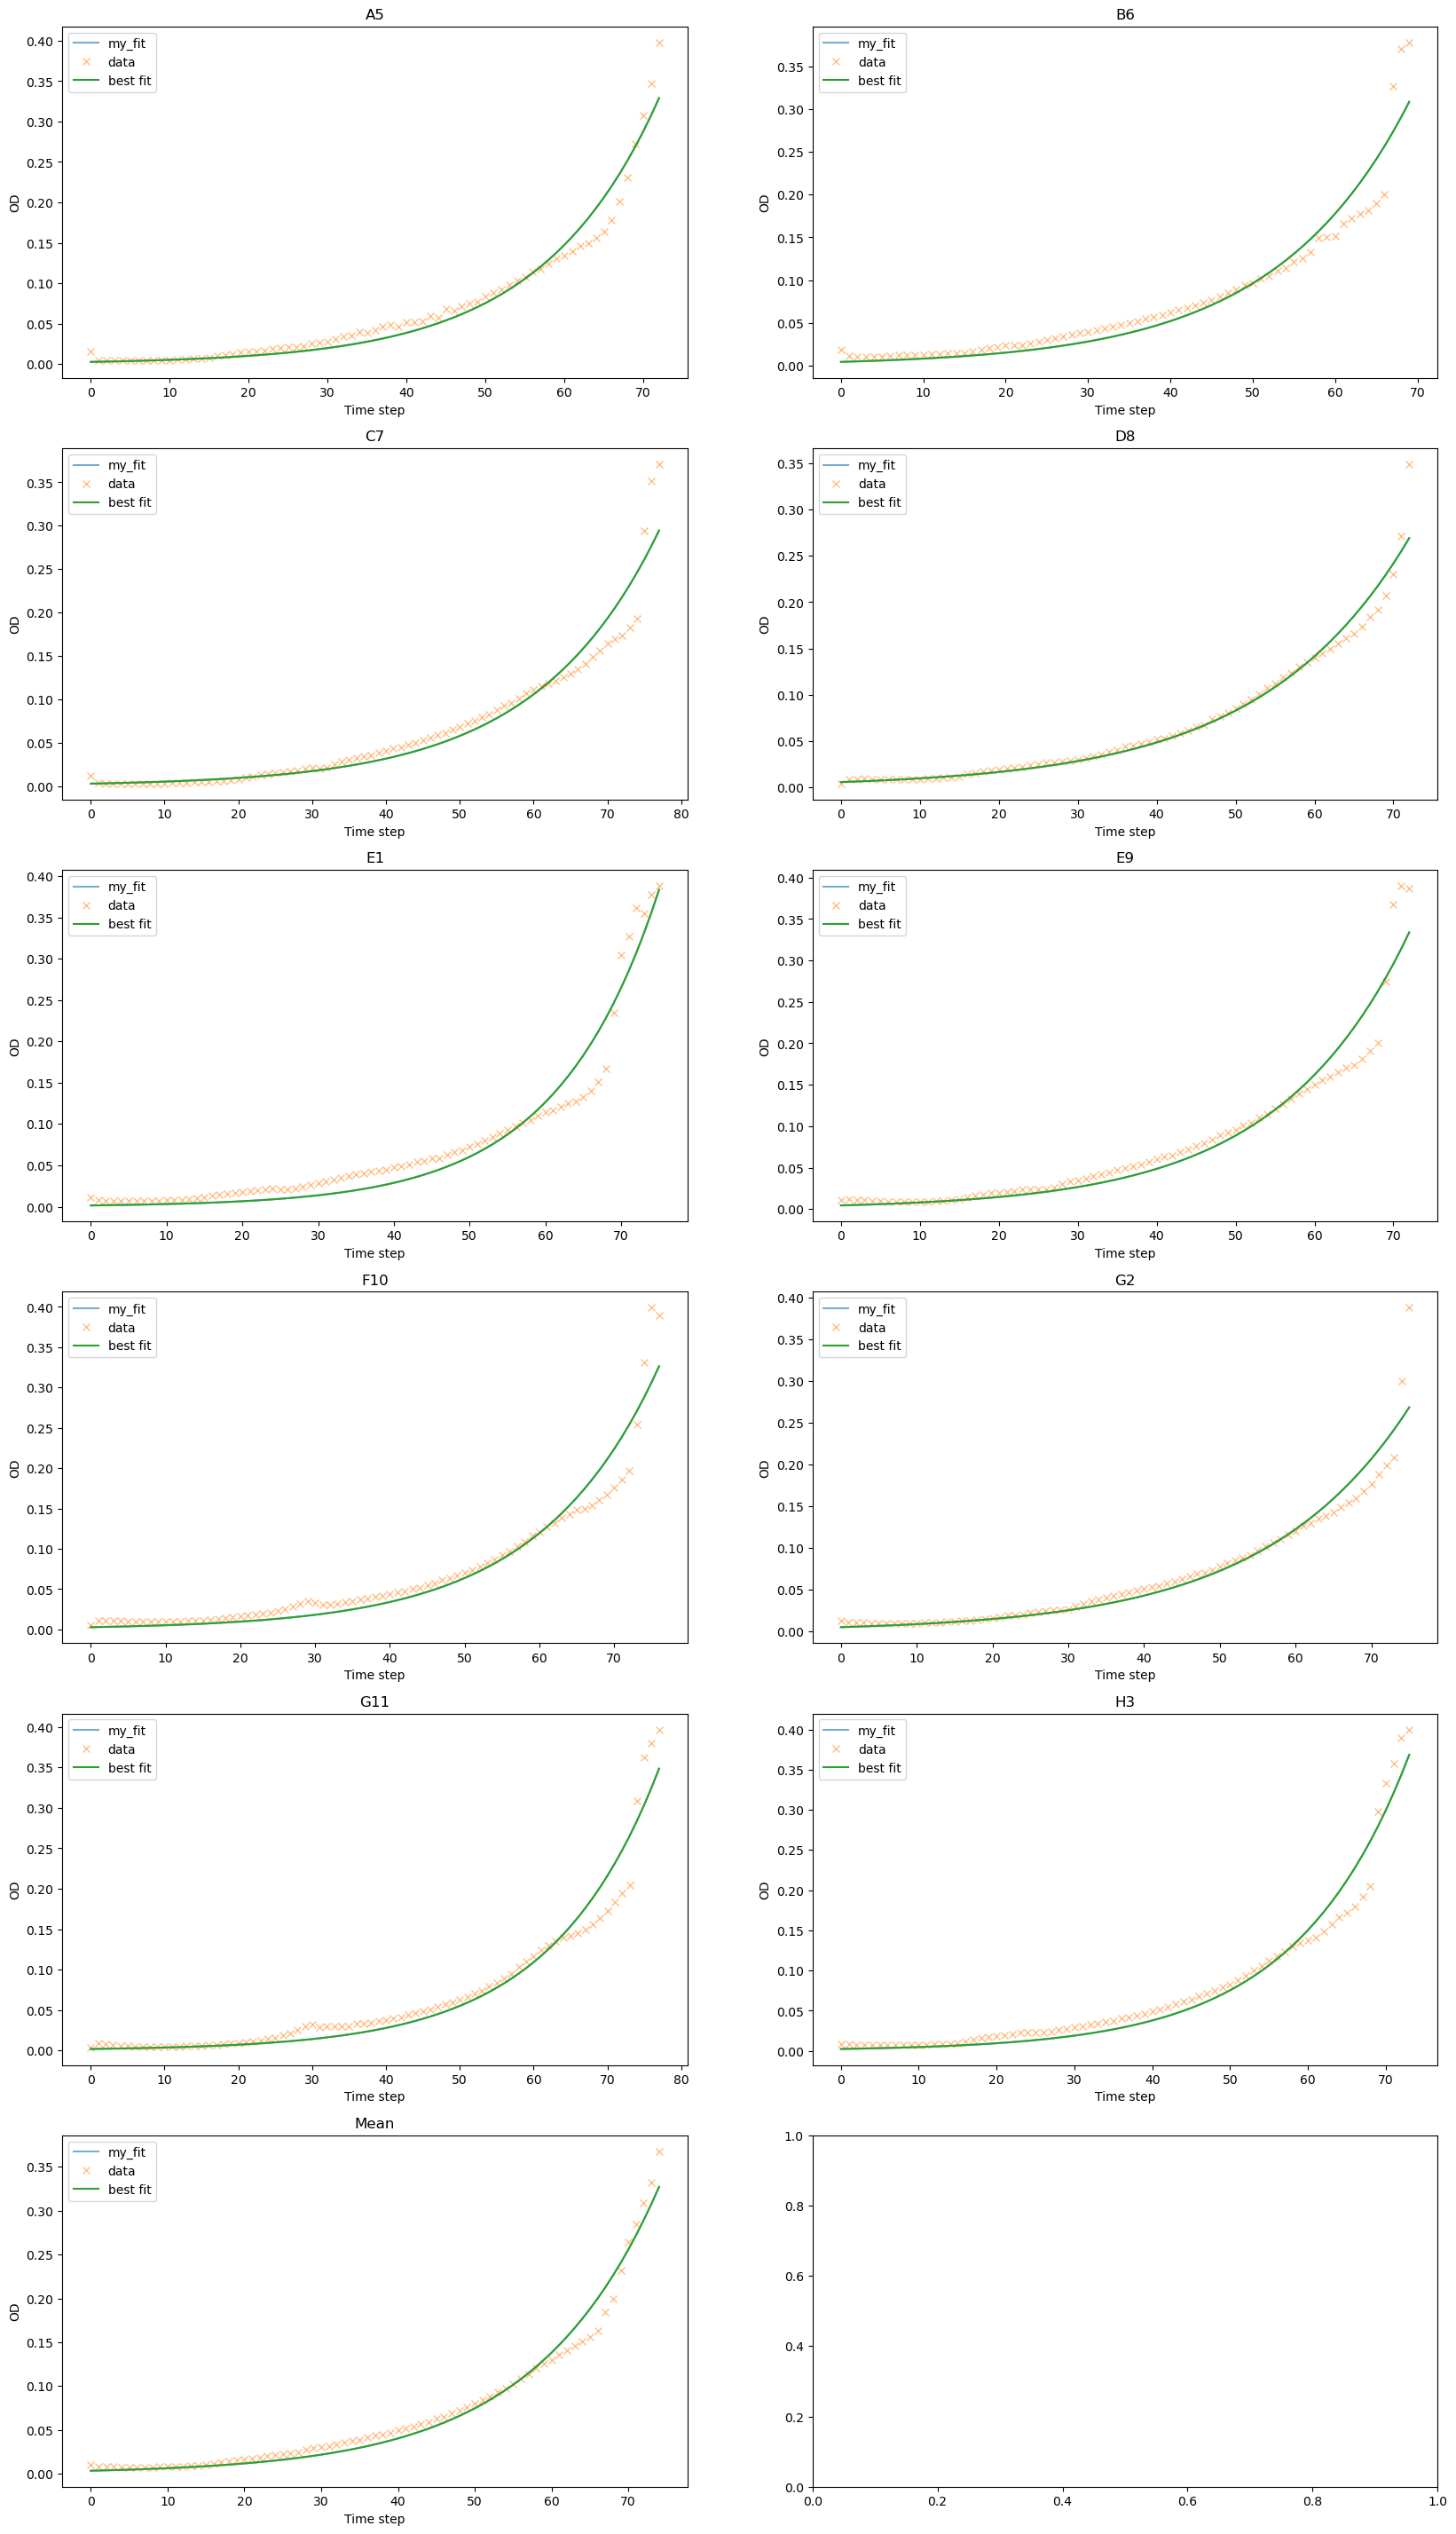

In [81]:
lmfit_params = lmfit_gc(df, np.append(col_names,'Mean'), single_scattering = True, compare = True, my_params=my_params, func=simple_logistic)

Let's get the correct growth rates and carrying capacities for the Richards model $$\mu = \frac{B}{\nu}$$

In [82]:
# Comparison of the exponent values found using my defined function vs the lmfit package 
lmfit_nu = {}
richards_nu = {}
for col in np.append(col_names, 'Mean'):
    lmfit_nu[col] = [1/lmfit_params[col]['sigma'], lmfit_params[col]['amplitude']]
    richards_nu[col] = [my_params[col]['B']/my_params[col]['nu'], my_params[col]['K']]
    print(col + f":\t lmfit: {lmfit_nu[col][0]} \t mine(richards): {richards_nu[col][0]}")

A5:	 lmfit: 0.06696949866414048 	 mine(richards): 0.0669694213908036
B6:	 lmfit: 0.0612650502281776 	 mine(richards): 0.061265562388007996
C7:	 lmfit: 0.060261512151090116 	 mine(richards): 0.060261473723219605
D8:	 lmfit: 0.0535627449275074 	 mine(richards): 0.0535625799094975
E1:	 lmfit: 0.07394651305966489 	 mine(richards): 0.07394646344202277
E9:	 lmfit: 0.06029179923721868 	 mine(richards): 0.0602917318784349
F10:	 lmfit: 0.0628282763536483 	 mine(richards): 0.06282823649390817
G2:	 lmfit: 0.05222890896465141 	 mine(richards): 0.052228777464189996
G11:	 lmfit: 0.06833011360487429 	 mine(richards): 0.06833000364110495
H3:	 lmfit: 0.06894159530961569 	 mine(richards): 0.0689416123481924
Mean:	 lmfit: 0.0615890188928576 	 mine(richards): 0.061588972858287225


From the data above we can see that they are in agreement

In [83]:
for col in np.append(col_names, 'Mean'):
    temp_lmfit_nu = 1/lmfit_params[col]['sigma']
    temp_richards_nu = my_params[col]['B']/my_params[col]['nu']
    print(col + f":\t diff: {temp_lmfit_nu - temp_richards_nu}")

A5:	 diff: 7.72733368820111e-08
B6:	 diff: -5.121598303930996e-07
C7:	 diff: 3.842787051067109e-08
D8:	 diff: 1.650180099024845e-07
E1:	 diff: 4.961764211997011e-08
E9:	 diff: 6.735878377989168e-08
F10:	 diff: 3.98597401196632e-08
G2:	 diff: 1.3150046141580107e-07
G11:	 diff: 1.0996376934024887e-07
H3:	 diff: -1.703857671619957e-08
Mean:	 diff: 4.6034570377884165e-08


In [84]:
# save the parameters into a csv file
pd.DataFrame(lmfit_nu).to_csv(CWD + '/data/wt_params.csv')
#pd.DataFrame(richards_nu).to_csv(CWD + '/data/delserCGA_params_updated.csv')
#pd.DataFrame(richards_nu).to_csv(CWD + '/data/M2lop_params.csv')

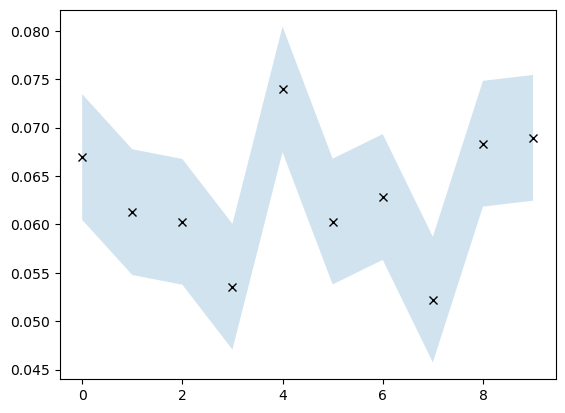

In [43]:
t = np.arange(len(col_names))
x = np.array(list(lmfit_nu.values()))
plt.plot(t, x, 'kx')
plt.fill_between(t, x-x.std(), x+x.std(), alpha = 0.2)


# Fit the full data

This part fits all the curve by using a combination of logistic + linear models

## Using my defined linear+logistic to fit to the data

In [382]:
def fit_lin_log(data, single_scattering = False):
    params = {}
    # Array representing time
    X = np.arange(data.shape[0])
    for i in data.columns.values[1:-1]:
        # Temporary dictionary to store fit parameters
        temp_params = ["K", "Q", "B", "nu", "m", "b"]
        
        # Array with the OD values
        y = data[i].values
        if single_scattering:
            y = y[y <= 0.4]
            X = np.arange(y.shape[0])
        
        # Initial position for optimization, initially using the same for all columns
        # Might be column dependant
        p0 = np.array([1, 0.5, 2, 2e-1, 3e-3, 0], dtype=np.longdouble)
        temp, cv = optimize.curve_fit(log_lin, X, y, p0, maxfev = 1000000)
        params[i] = dict(zip(["K", "Q", "B", "nu", "m", "b"], temp))
    
    return params      


In [383]:
def plot_fit(data, params):
    nrows = len(params) // 2
    fig, ax = plt.subplots(nrows = nrows, ncols = 2, figsize = (20, 6 * nrows), sharex = False)
    #fig.subplots_adjust(hspace=0)
    X = np.arange(data.shape[0])
    for i, axes in enumerate(ax.flat):
        col = list(params.keys())[i]
        axes.plot(log_lin(X, *list(params[col].values())))
        axes.plot(X, df[col], 'x-', alpha = 0.5)
        axes.set_title(col);



    

In [318]:
params = fit_lin_log(df[1:-1])

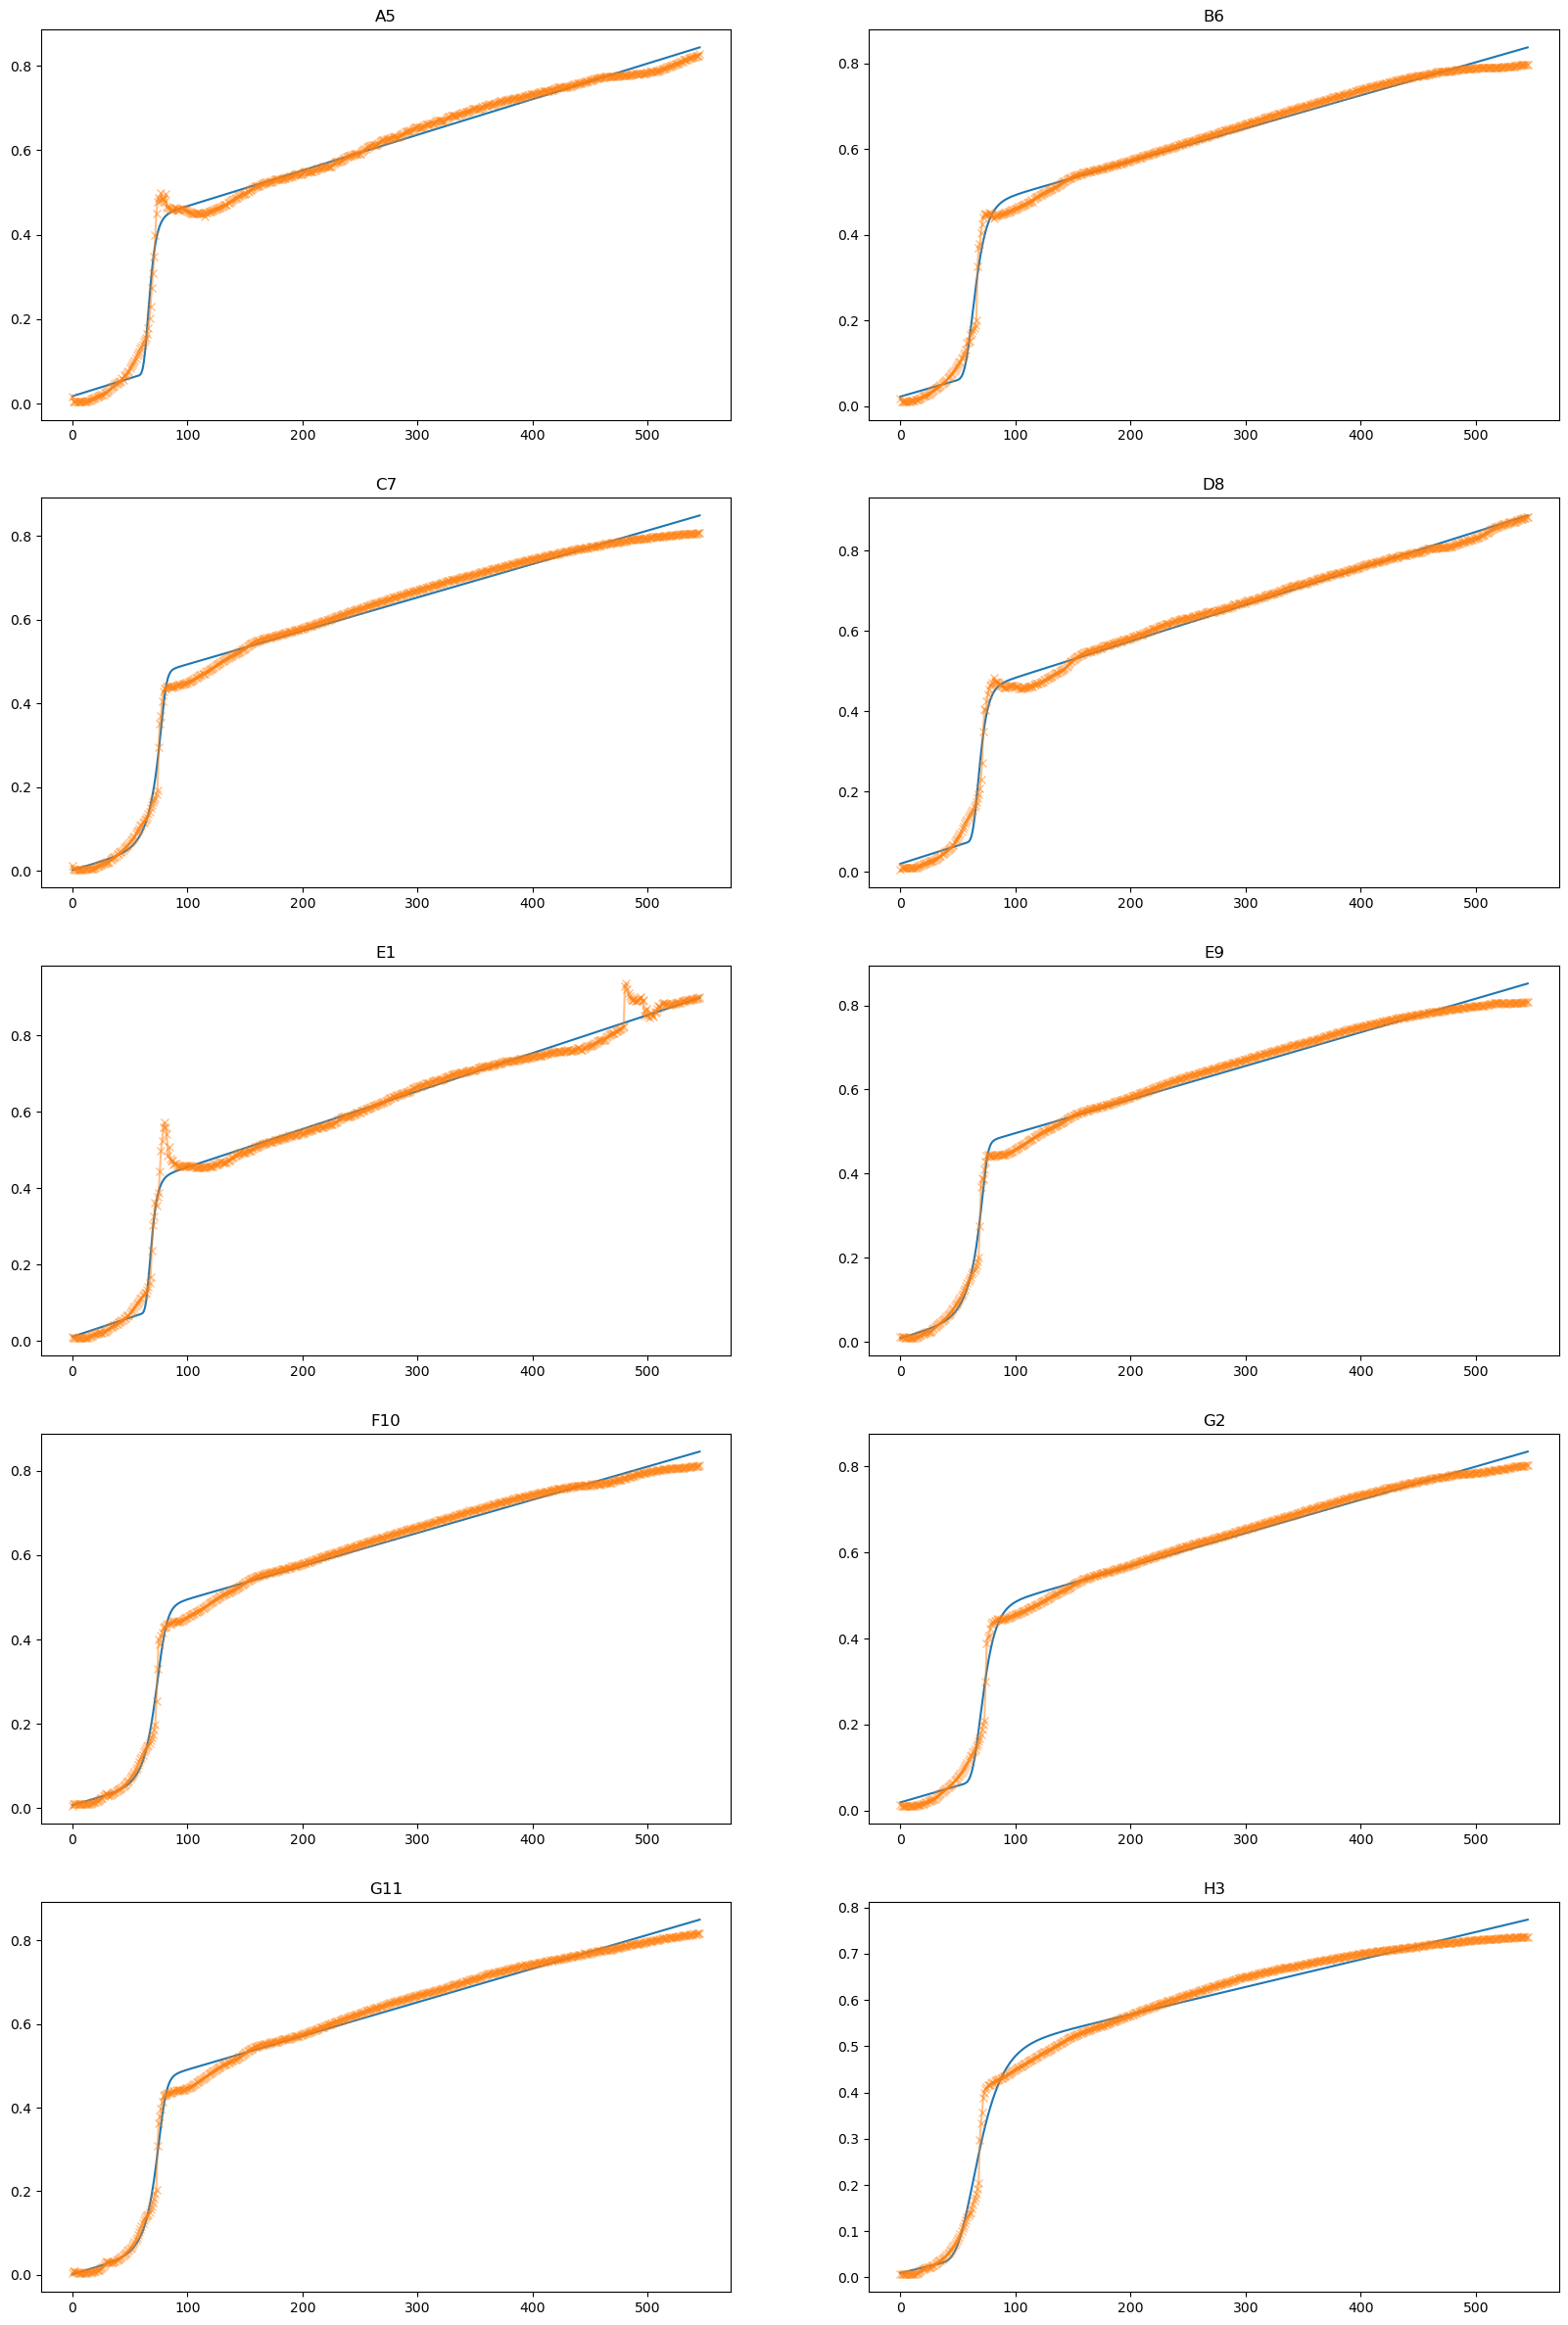

In [319]:
# Plot the fit curves, the titles refer to the plate position
plot_fit(params)

In [247]:
# Uncomment if need to save the parameters again
#pd.DataFrame(params).to_csv(CWD + '/data/fit_gc_wt.csv')

Run the fit with my defined function for the mutant types

In [369]:
serCGA_path = os.path.join(CWD, "data/gc_delserCGA.csv")
serCGA_df = pd.read_csv(serCGA_path)

In [370]:
serCGA_params = fit_lin_log(serCGA_df[1:-1])

In [372]:
# Uncomment if need to save the parameters again
# pd.DataFrame(serCGA_params).to_csv(CWD + '/data/fit_gc_delserCGA.csv')

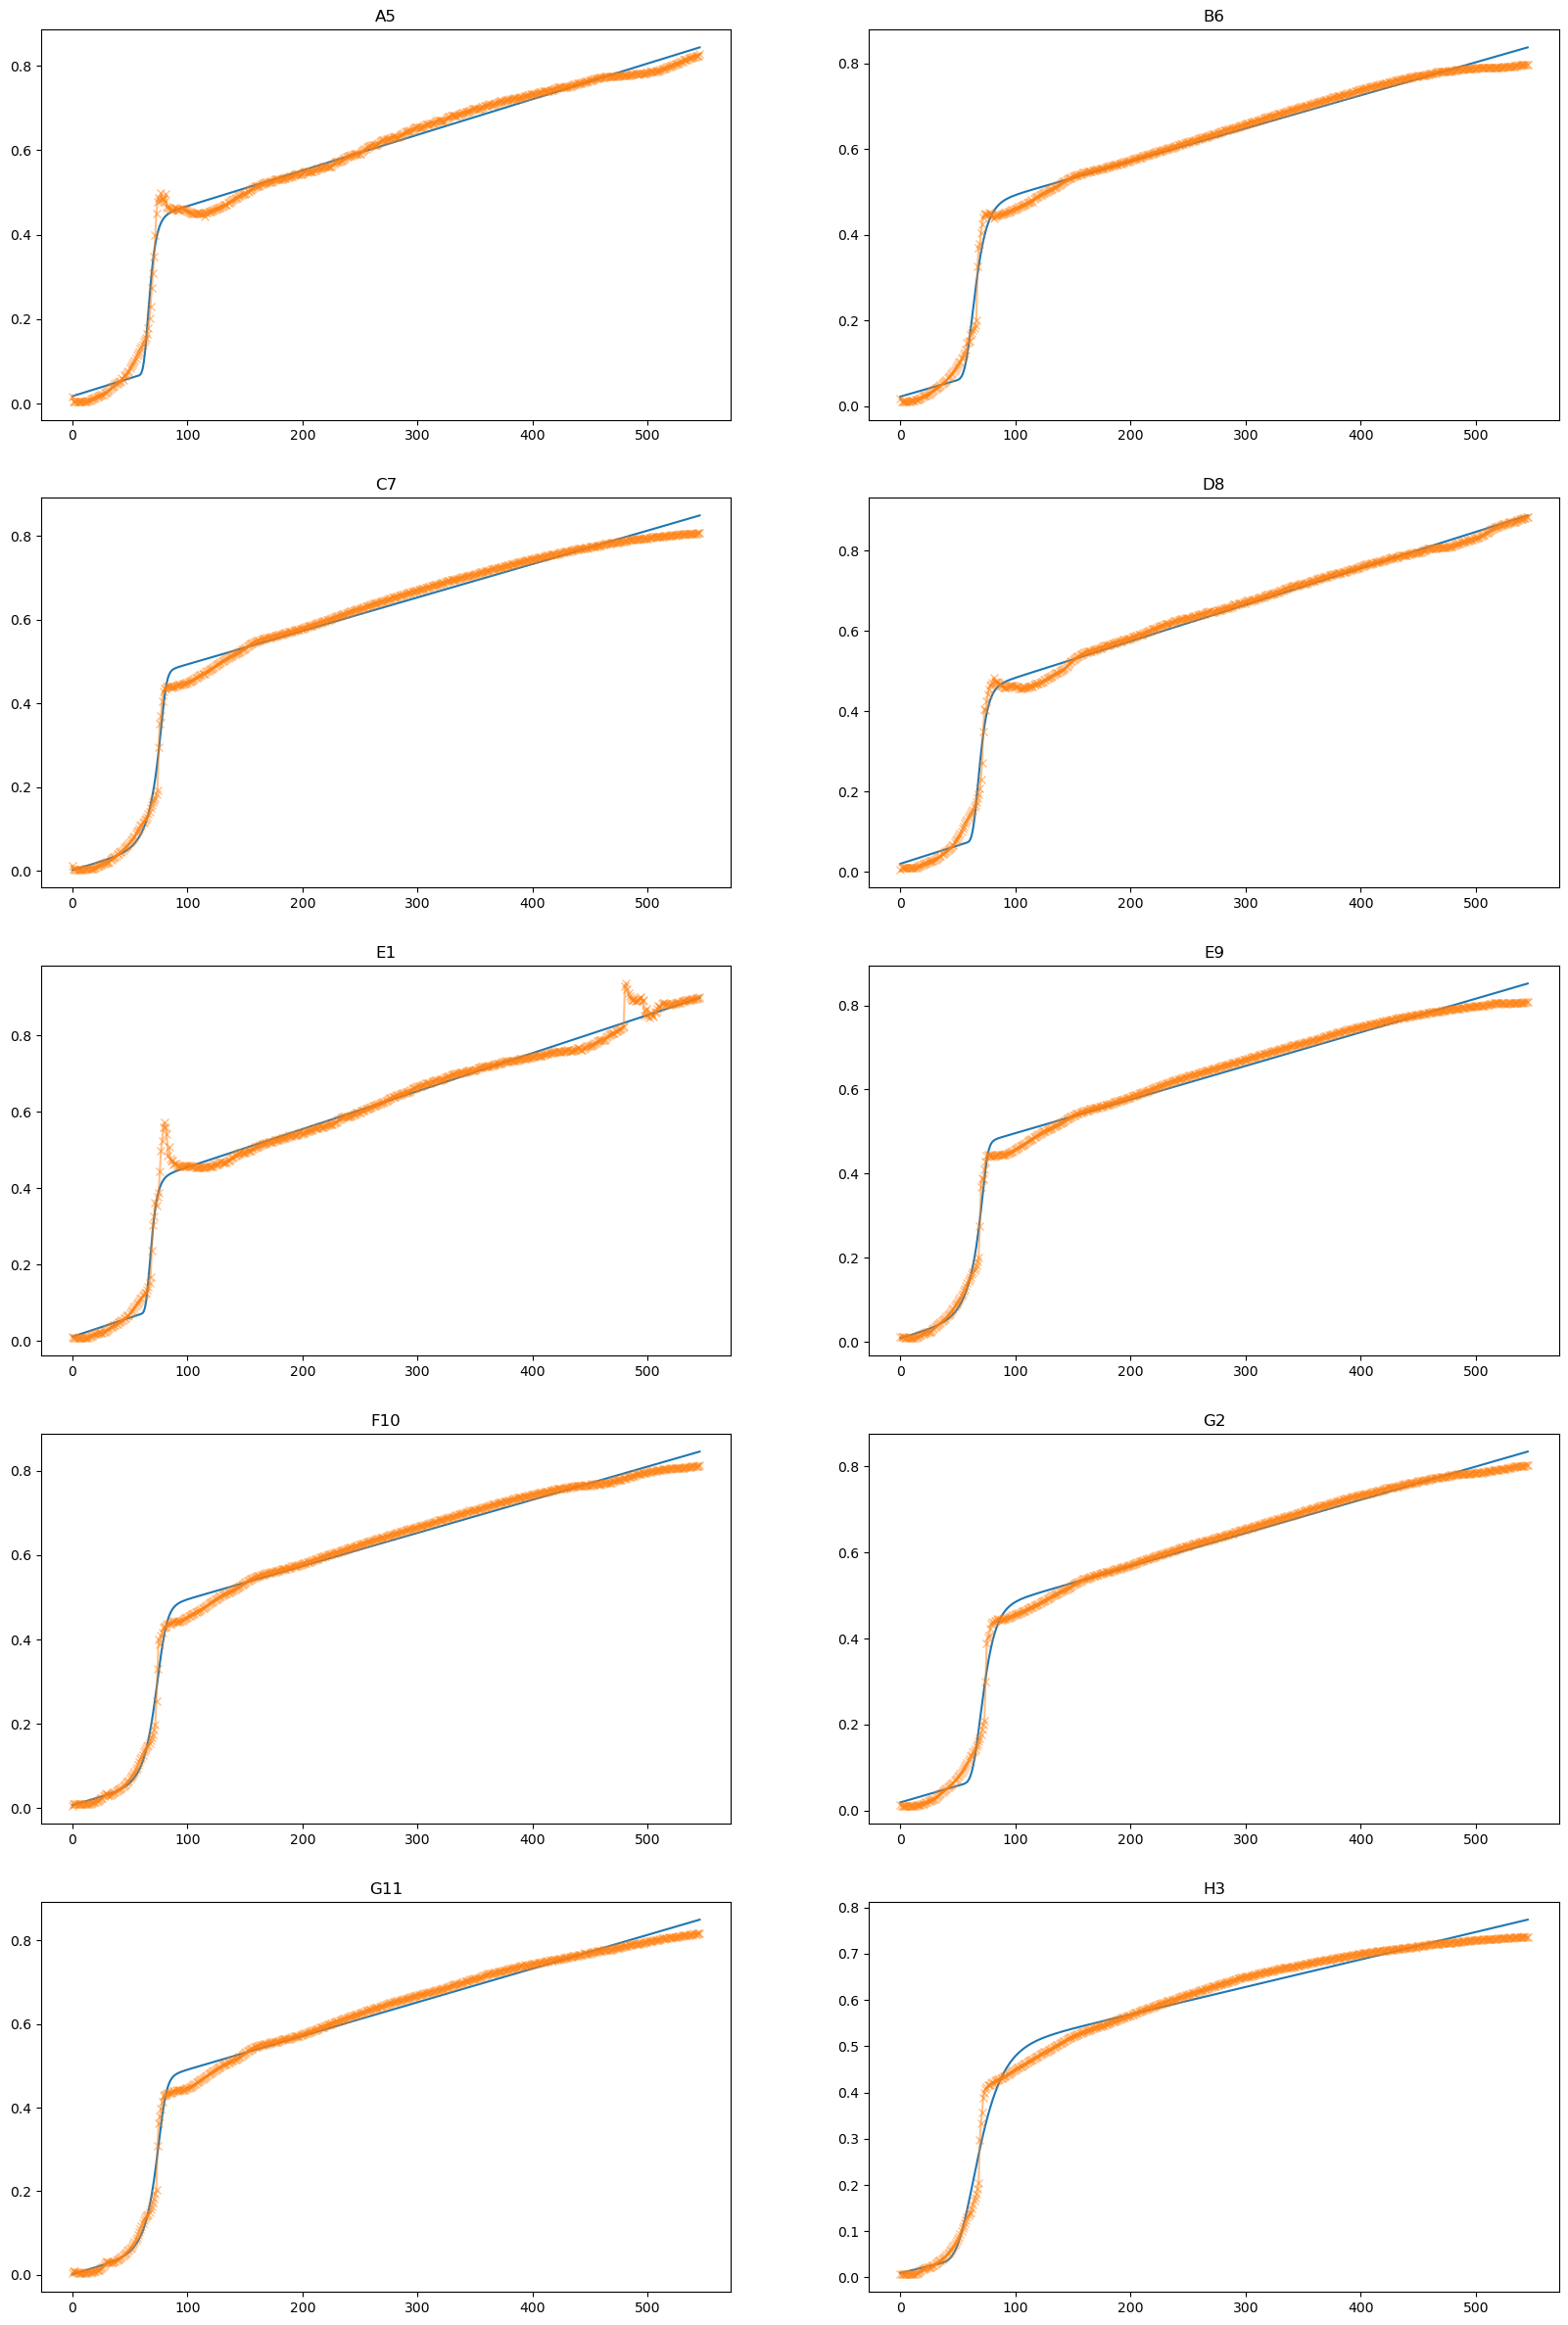

In [371]:
plot_fit(serCGA_params)

# Using lmfit to compare the results of the fit

Let's try the fit with the lmfit library which returns confidence intervals as well


  logistic_den = K/np.float_power(1 + Q * np.exp(-B * x), 1 / nu)
    logistic = K / logistic_den 

In [465]:
gmodel1 = StepModel(form = 'logistic') + LinearModel()

In [305]:
result1 = gmodel1.fit(y, x=X)

In [304]:
gmodel1.param_names

['amplitude', 'center', 'sigma', 'slope', 'intercept']

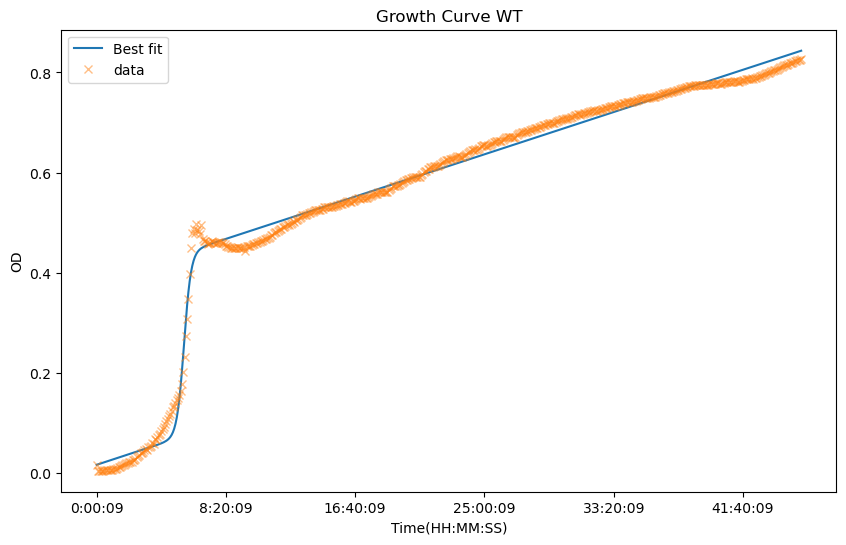

In [342]:
plt.figure(figsize = (10,6))
#plt.plot(X, result1.init_fit, '--', label='initial fit')
#plt.plot(X, result.best_fit, '-', label='best fit')
plt.plot(X, result1.best_fit, '-', label='Best fit')
plt.plot(X, y, 'x', alpha = 0.5, label = 'data')
plt.legend();
plt.xticks(np.arange(0,501,100),list(df['Time'].values[np.arange(0,501,100)]));
plt.xlabel('Time(HH:MM:SS)');
plt.ylabel('OD');
plt.title('Growth Curve WT');
plt.savefig('gc_fit.png', dpi = 300);

In [307]:
print(result1.fit_report())

[[Model]]
    (Model(step, form='logistic') + Model(linear))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 520
    # data points      = 546
    # variables        = 5
    chi-square         = 0.15936017
    reduced chi-square = 2.9457e-04
    Akaike info crit   = -4434.00725
    Bayesian info crit = -4412.49416
    R-squared          = 0.99422309
[[Variables]]
    amplitude:  0.36699806 +/- 0.00294170 (0.80%) (init = 1)
    center:     67.5745612 +/- 0.19817883 (0.29%) (init = 0)
    sigma:      2.72752872 +/- 0.17385996 (6.37%) (init = 1)
    slope:      8.4503e-04 +/- 5.8772e-06 (0.70%) (init = 1)
    intercept:  0.01585602 +/- 0.00225557 (14.23%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, intercept) = -0.7352
    C(amplitude, slope)     = -0.5802
    C(amplitude, sigma)     = +0.2864
    C(center, intercept)    = +0.2592
    C(sigma, intercept)     = -0.2156
    C(sigma, slope)         = -0.1592
    C(center, slo

In [321]:
result1.best_values

{'slope': 0.0008450307677808628,
 'intercept': 0.01585602061888991,
 'form': 'logistic',
 'amplitude': 0.36699806227738974,
 'center': 67.57456118636935,
 'sigma': 2.727528722736964}

In [322]:
def lmfit_lin_log(data):
    result = {}
    # Array representing time
    X = np.arange(df.shape[0])
    for i in df.columns.values[1:-1]:
        gmodel = StepModel(form = 'logistic') + LinearModel()
        # Array with the OD values
        y = df[i].values
        
        # Initial position for optimization, initially using the same for all columns
        # Might be column dependant
        temp_result = gmodel.fit(y, x=X)
        result[i] = temp_result
    
    return result

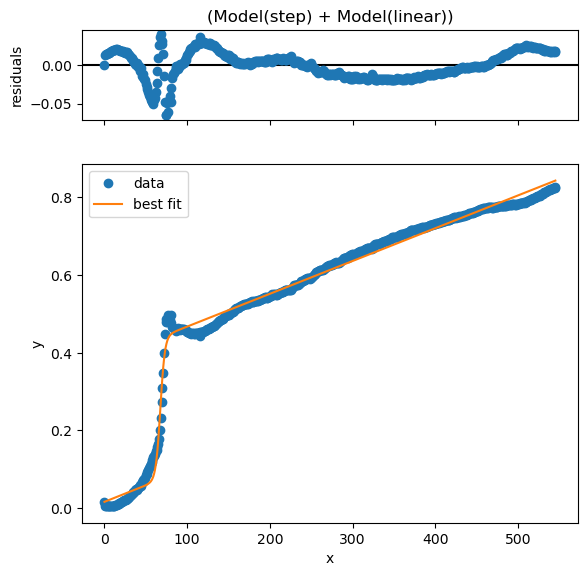

In [328]:
lmfit_lin_log(df)['A5'].plot();

In [345]:
test =lmfit_lin_log(df)

In [362]:
test

{'A5': <lmfit.model.ModelResult at 0x280d853f0>,
 'B6': <lmfit.model.ModelResult at 0x280d848b0>,
 'C7': <lmfit.model.ModelResult at 0x280d67430>,
 'D8': <lmfit.model.ModelResult at 0x280d86f50>,
 'E1': <lmfit.model.ModelResult at 0x280d642b0>,
 'E9': <lmfit.model.ModelResult at 0x280d64fd0>,
 'F10': <lmfit.model.ModelResult at 0x281a2f6d0>,
 'G2': <lmfit.model.ModelResult at 0x280d85bd0>,
 'G11': <lmfit.model.ModelResult at 0x280d67e80>,
 'H3': <lmfit.model.ModelResult at 0x280d660e0>}

In [357]:
results_dict ={}
for i in ['gc_delserCGA.csv', 'gc_wt.csv']:
    temp_fn = i
    save_fn = i.strip().split('.')[0]
    temp_path = os.path.join(CWD, "data", temp_fn)

    temp_df = pd.read_csv(temp_path)
    X = np.arange(temp_df.shape[0])
    temp_dict = {}
    for j in temp_df.columns[1:-1]:
        y = temp_df[j].values
        
        gmodel = StepModel(form = 'logistic') + LinearModel()
        result = gmodel.fit(y, x = X)
        temp_dict[j] = result.best_values
    
    results_dict[save_fn] = temp_dict

In [360]:
for i in results_dict.keys():
    pd.DataFrame(results_dict[i]).to_csv('param_{}.csv'.format(i))